In [197]:
import numpy as np
import pandas as pd

## Update of Delta Beta

We have : 
- X an n*p matrix
- X = [x_1, ..., x_p], with x_i a vector of length n.
- x_i = [x_i1, ..., x_in], where x_ij is a scalar. 
- \beta = [beta_1, ..., beta_p], where beta_i is a scalar. So beta is a vector of length p.


In [198]:
def T(u,a):
    return np.sign(u)*max(np.abs(u)-a,0)

#Reminder
#x is the vector x_i = [x_i1, ..., x_in]
#beta is the coefficient vector beta = [beta_i1, ..., beta_ip]

def pi(beta,xi):
    return 1/(1+np.exp(-np.dot(beta,xi)))

def wi(beta,xi):
    return pi(beta,xi)*(1-pi(beta,xi))
    
def zi(beta,xi,yi):
    return (((yi+1)/2)-pi(beta,xi))/wi(beta,xi)

#### Commentaire 1: Ton zi ce serait pas plutôt --> OK

In [199]:
#dbeta is the vector dbeta = [dbeta_i1, ..., dbeta_ip]

def qi(beta, dbeta, xi, yi, j):
    return zi(beta,xi,yi) - np.dot(dbeta,xi) + (beta[j] + dbeta[j])*xi[j]

In [200]:
def dbetaj_optimal(beta, dbeta_k, X, y, j, lambd): 
    w = np.array([wi(beta,X[i,:]) for i in range(X.shape[0])])
    q = np.array([qi(beta, dbeta_k, X[i,:], y[i], j) for i in range(X.shape[0])])
    wq = np.array([w[i]*q[i] for i in range(len(q))])
    num = T(np.dot(wq,X[:,j]), lambd)
    den = np.dot(w,np.square(X[:,j]))
    return (num/den) - beta[j]

#def partition(p, M):
#    original_set = np.arange(p)
#    S = []
#    for i in range(M):
#        choosen = np.random.choice(original_set,np.int(p/M),replace=False)
#        S.append(choosen)
#        original_set = np.delete(original_set, choosen)
#    return np.array(S)

#### Commentaire 2: On modifie la fonction partition car elle répète plusieurs fois les mêmes nombres dans la matrice. Je sais pas si t'as python 2 ou 3, ya peut-être une différence dûe à ca... ---> OK

In [201]:
# Fonction partition corrigée
def partition(p, M):
    original_set = np.arange(p)
    S = []
    for i in range(M):
        choosen = np.random.choice(original_set,np.int(p/M),replace=False)
        S.append(choosen)
        original_set = np.setdiff1d(original_set, choosen) # J'ai changé np.delete par np.setdiff1d
    return np.array(S)

In [202]:
# Line search
# Packages needed

import numpy as np
import itertools
from scipy import optimize

# Bricks for the line search

def loss_function(X,Y,beta):
    y_beta_x = np.multiply(Y,X.dot(beta))
    return sum(np.log(1+np.exp(-y_beta_x)))

def penalty(beta,regularization):
    return regularization*np.linalg.norm(beta, ord=1)

def functional(X,Y,beta,regularization):
    return loss_function(X,Y,beta)+penalty(beta,regularization)

def gradient_loss(X,Y,beta):
    gradient = []
    for j in range(len(beta)):
        y_beta_x = Y*X.dot(beta)
        y_xj = Y*X[:,j]
        gradient_betaj = sum((-y_xj*np.exp(-y_beta_x))/(1+np.exp(-y_beta_x)))
        gradient.append(gradient_betaj)
    return np.array(gradient)

def second_gradient_loss(X,Y,beta,variable_j,variable_l):
    y_beta_x = Y*X.dot(beta)
    ysq_xj_xl = Y**2*(X[:,variable_j]*X[:,variable_l])
    gradient_betajl = sum((ysq_xj_xl*np.exp(-y_beta_x)*(1+np.exp(-y_beta_x)) + Y*(X[:,variable_l])*np.exp(-y_beta_x)*(-Y*(X[:,variable_j])*np.exp(-y_beta_x)))/(1+np.exp(-y_beta_x))**2)
    return gradient_betajl

def H_tilde(X,Y,beta):
    # Combination of all possible indexes
    iterator = list(itertools.product([i for i in range(len(beta))], [i for i in range(len(beta))]))
    # Initialize H_tilde matrix
    H_tilde = np.empty((len(beta),len(beta),))
    H_tilde[:] = np.nan
    for i in iterator:
        H_tilde[i[0],i[1]] = second_gradient_loss(X,Y,beta,i[0],i[1])
    return H_tilde

def D(X,Y,beta,delta_B,regularization):
    return gradient_loss(X,Y,beta).dot(delta_B) + gamma*delta_B.dot(H_tilde(X,Y,beta)).dot(delta_B) + regularization*(np.linalg.norm(beta-delta_B, ord=1)-np.linalg.norm(beta, ord=1))

def line_search(X,Y,beta,regularization, delta_B, sufficient_decrease, delta, b, sigma, gamma):
    if functional(X,Y,beta,regularization) - functional(X,Y,beta+delta_B,regularization) > sufficient_decrease:
        return 1
    else:
        result = optimize.minimize_scalar(lambda x: functional(X,Y,beta+(x*delta_B),regularization), bounds=(delta,1), method='Bounded')
        alpha_in = result.x
        alpha = alpha_in
        count = 0
        while functional(X,Y,beta+alpha*delta_B,regularization) > functional(X,Y,beta,regularization) + alpha*sigma*D(X,Y,beta,delta_B,regularization):
            count += 1
            alpha *= b**count
        return alpha

In [203]:
#Simulation 
from scipy.linalg.special_matrices import toeplitz
n = 1000
p = 50  #il faut que p soit divisible par M
corr = 0.8
std = 1
cov = toeplitz(corr ** np.arange(0, p))
X = np.random.multivariate_normal(np.zeros(p),cov,size=n)
noise = std * np.random.randn(n)
idx = np.arange(1,p+1)
beta_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)
y = np.sign(X.dot(beta_truth) + noise)

In [204]:
len(set(partition(p, M).ravel()))
# On a que 36 valeurs distinctes dans la matrice alors que l'on devrait en avoir 50
print(partition(p,M))

[[48  2 46 43  9]
 [47 32 31  3 20]
 [42 40 44 22  7]
 [45 33 11 23 27]
 [26 36  1  8 39]
 [38 49  5 12 18]
 [ 0 28  4 25  6]
 [34 37 15 24 30]
 [13 17 19 10 35]
 [29 14 41 16 21]]


#### Commentaire 3: Il y a peut-être un problème dans l'utilisation de la fonction dbetaj_optimal. On passe dbeta_M[i,:] en argument alors qu'il faudrait plutôt passer dbeta.

# SIMULATION STARTS HERE

In [205]:
#Test Simulation
beta = np.zeros(X.shape[1])
M = 10
lambd = 1. / n ** (0.5)
S = partition(p,M)
dbeta_M = np.zeros((M,p))
dbeta = np.zeros(p)
# Parameters to set for the line search
sufficient_decrease = 10
delta = .2
b = .5
sigma = .01
gamma = 0



In [206]:
# Dictionary to see after of the coefficients converge to the true ones ofter some iterations

dict_df = {'True coefficients': beta_truth}
rate_iter = []
loss = []
func = []

In [210]:
# Convergence criteria: relative decrease in the objective is sufficiently small or maximum number of iteration
# has been reached. From now I only used a maximum number of iterations to reach.
max_iter = 30
# Dictionary to see after of the coefficients converge to the true ones ofter some iterations
beta = np.zeros(X.shape[1])
dict_df = {'True coefficients': beta_truth}
rate_iter = []
loss = []
func = []
beta_error = []
count = 0
dict_df.update({'{} iter'.format(count): beta})

while (count < max_iter):
    if (count+1) % 10 ==0 : 
        print("iteration number ", count+1)
    # 1. Do in parallel over M machines
    for i in range(M):
    # 2. Minimize the objective
        for j in S[i]:
            dbeta_M[i,j] = dbetaj_optimal(beta, dbeta_M[i,:], X, y, j, lambd) # Avant on mettait dbeta_M[i,:] à
            #la place de dbeta --> ce que j'ai fait était bon on peut en parler au tel stv
    # 3. Put together the found delta beta
    dbeta = np.sum(dbeta_M, 0)
    # 4. Find the rate using line search
    rate = line_search(X, y, beta, lambd, dbeta, sufficient_decrease, delta, b, sigma, gamma)
    # 5. Find the new betas
    beta = beta + rate * dbeta
    error = np.linalg.norm(beta-beta_truth)
    count += 1
    # Look at some metrics to see how our algorithm behaves
    beta_error.append(error)
    rate_iter.append(rate)
    loss.append(loss_function(X,y,beta))
    func.append(functional(X,y,beta,lambd))
    dict_df.update({'{} iter'.format(count): beta})

iteration number  10
iteration number  20
iteration number  30


In [211]:
pd.DataFrame({'rate': rate_iter, 'Loss function': loss, 'Functional': func, 'Beta Error': beta_error}, index = ['Iteration nb {}'.format(i) for i in range(len(rate_iter))] )

,Beta Error,Functional,Loss function,rate
Iteration nb 0,2.061932,650.662117,650.613532,0.397088
Iteration nb 1,1.915784,629.445421,629.387451,0.253795
Iteration nb 2,1.789493,615.621362,615.542172,0.334808
Iteration nb 3,1.627113,601.362693,601.256153,0.299268
Iteration nb 4,1.534896,591.448023,591.321240,0.277129
Iteration nb 5,1.394106,581.624196,581.469789,0.340832
Iteration nb 6,1.334167,574.240216,574.070308,0.257508
Iteration nb 7,1.228128,567.336557,567.141184,0.365827
Iteration nb 8,1.188698,561.678314,561.471345,0.251366
Iteration nb 9,1.111564,556.535004,556.305786,0.377166


In [212]:
pd.DataFrame(dict_df) #--> Il faut ordonner les itérations

,0 iter,1 iter,10 iter,11 iter,12 iter,13 iter,14 iter,15 iter,16 iter,17 iter,...,29 iter,3 iter,30 iter,4 iter,5 iter,6 iter,7 iter,8 iter,9 iter,True coefficients
0,0,0.272600,0.874436,0.914712,0.965924,1.000015,1.043466,1.072338,1.108868,1.133578,...,1.356560,0.451568,1.368265,0.516799,0.580936,0.647909,0.702374,0.768053,0.815224,0.904837
1,0,0.129298,-0.647577,-0.678882,-0.741634,-0.765006,-0.816656,-0.835313,-0.879611,-0.895463,...,-1.130099,-0.030907,-1.148141,-0.156827,-0.239319,-0.362351,-0.422927,-0.524528,-0.568090,-0.818731
2,0,0.054651,0.700640,0.722923,0.755257,0.770069,0.794263,0.805666,0.826293,0.836496,...,0.988474,0.225183,1.000929,0.322767,0.401349,0.493113,0.547811,0.617618,0.653087,0.740818
3,0,0.070638,-0.348973,-0.356087,-0.412506,-0.417972,-0.467860,-0.472171,-0.516583,-0.520111,...,-0.721372,0.001823,-0.743814,-0.083206,-0.100699,-0.186604,-0.199779,-0.274816,-0.284323,-0.670320
4,0,0.032556,0.180097,0.208804,0.242329,0.271087,0.305145,0.332535,0.364897,0.390266,...,0.640820,0.050586,0.656396,0.051221,0.069376,0.079588,0.102057,0.123784,0.150404,0.606531
5,0,0.018919,-0.270227,-0.271201,-0.314514,-0.316744,-0.357972,-0.361028,-0.399923,-0.403494,...,-0.608863,-0.061216,-0.631802,-0.123269,-0.123743,-0.178096,-0.176514,-0.225278,-0.224688,-0.548812
6,0,0.014750,0.244518,0.270338,0.285634,0.307747,0.320546,0.340006,0.351126,0.368672,...,0.499487,0.046282,0.505598,0.063494,0.108545,0.133831,0.171487,0.194677,0.225622,0.496585
7,0,-0.002216,-0.263591,-0.262382,-0.306672,-0.306294,-0.347272,-0.347254,-0.384822,-0.384986,...,-0.554434,-0.071034,-0.574903,-0.128012,-0.120928,-0.173882,-0.168795,-0.219007,-0.216208,-0.449329
8,0,0.050185,0.162747,0.199578,0.194256,0.227880,0.224214,0.255132,0.252636,0.281237,...,0.411222,0.075346,0.410487,0.053311,0.108257,0.093577,0.139992,0.129460,0.170310,0.406570
9,0,0.014998,-0.103553,-0.082073,-0.111534,-0.092156,-0.119024,-0.101435,-0.126104,-0.110110,...,-0.155250,-0.034190,-0.170656,-0.080919,-0.047505,-0.087051,-0.058967,-0.095075,-0.070957,-0.367879


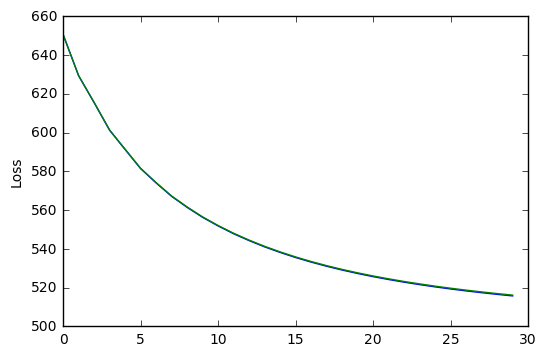

In [217]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.plot(func)
plt.ylabel('Loss')
plt.show()

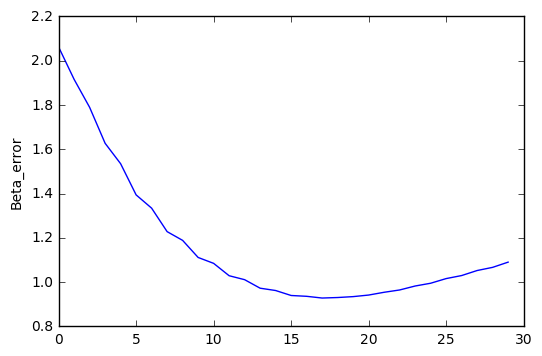

In [220]:

plt.plot(beta_error)
plt.ylabel('Beta_error')
plt.show()